# Plotting

## Using [matplotlib](https://matplotlib.org/)

Up to this point we have been plotting our maps using the `matplotlib` package, which is built into `geopandas`. While `matplotlib` is both easy to use and already known to many python users (as it is popular for graphing in general), it has the drawback that it is not interactive.

## Using [folium](http://python-visualization.github.io/folium/)

`folium` is a python package built to allow the use of `leaflet`, an open-source JavaScript library. `leaflet` is an interactive map development toolkit that powers a lot of web-based interactive maps. Alternatives to `leaflet` include [MapBox](https://www.mapbox.com/), [Google Maps](https://developers.google.com/maps/documentation), as well as many other paid services.

Also built upon `leaflet` is `ipyleaflet`, which is a package designed specifically for rendering `leaflet` maps in Jupyter Notebook. While leaflet is highly interactive and easily builds beautiful maps with little configuration, it depends on JavaScript in order to function.

Let's replot the above map in `folium`. Note that `folium` expects geospatial data to be in `EPSG:4326`.

In [4]:
import geopandas as gpd
import folium

# file downloaded from https://data.ontario.ca/dataset/ontario-s-health-region-geographic-data
ontario = gpd.read_file(r"../../data/ontario_health_regions/Ontario_Health_Regions.shp")
ontario = ontario[(ontario.REGION != "North")]
ontario = ontario.to_crs(epsg=4326)

# Set starting location, initial zoom, and base layer source.
m = folium.Map(location=[43.67621,-79.40530],zoom_start=6, tiles='cartodbpositron')

for index, row in ontario.iterrows():
    # Simplify each region's polygon as intricate details are unnecessary
    sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, name=row['REGION'],style_function=lambda x: {'fillColor': 'black'})
    folium.Popup(row['REGION']).add_to(geo_j)
    geo_j.add_to(m)

m

:::{note}
You can click anywhere inside the marked regions to show a popup indicating the region's name.
This folium map uses OpenStreetMaps's CartoDB styling for a base layer tileset. You can read more about using custom tilesets [here](http://python-visualization.github.io/folium/modules.html#module-folium.folium).
:::

## Elevation Data

We can also retrieve interesting geospatial information in the form of elevation data.

Let's first get the centroids for each region:

In [5]:
ontario['centroid'] = ontario.centroid
ontario

/tmp/ipykernel_12262/4260188429.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ontario['centroid'] = ontario.centroid


,Shape_Leng,Shape_Area,REGION,REGION_ID,geometry,centroid
0,4.845977e+06,1.089122e+11,East,04,"MULTIPOLYGON (((-77.54191 43.89913, -77.54234 ...",POINT (-77.18411 44.89013)
2,4.860262e+06,7.543033e+10,West,01,"MULTIPOLYGON (((-82.68871 41.68453, -82.68631 ...",POINT (-81.07741 43.36065)
3,2.755817e+06,3.189867e+10,Central,02,"MULTIPOLYGON (((-79.70667 43.39271, -79.70805 ...",POINT (-79.65677 44.45330)
4,2.196396e+05,3.715020e+08,Toronto,03,"MULTIPOLYGON (((-79.40671 43.74414, -79.40648 ...",POINT (-79.40531 43.67619)


:::{warning}
Notice that calculating the centroid raises a warning. That's because we are using `EPSG:4326`, which uses degrees as a unit of measure. This makes polygon calculations inaccurate, especially at larger scales. We will ignore this warning for this example, but keep in mind that centroids will not be accurate in this projection. For better results, you can calculate the centroids of a projection that uses a flat projection (that retains area) and then reproject it back to `EPSG:4326`. 

For web use, when the desired effect is a *visual* centroid, it is possible to continue using a Mercator projection like `EPSG:4326`, while applications that require a "true" centroid should use a projection like `Equal Area Cylindrical`, which avoids distortion at the poles. See [here](https://proj.org/operations/projections/cea.html) for more details.
:::

Now, let's query the [Open Elevation API](https://open-elevation.com/) for the elevation (in metres) at the centroids for each region.

In [6]:
from requests import get

def get_elevation(centroid):
    query = (f'https://api.open-elevation.com/api/v1/lookup?locations={centroid.y},{centroid.x}')

    # Set a timeout on the request in case of a slow response
    r = get(query,timeout=30)

    # Only use the response if the status is successful
    if r.status_code!=200 and r.status_code!=201: return None

    elevation = r.json()['results'][0]['elevation']
    return elevation

elevations = []

for index, row in ontario.iterrows():
    elevations.append(get_elevation(row['centroid']))
    
ontario['elevations'] = elevations
ontario

,Shape_Leng,Shape_Area,REGION,REGION_ID,geometry,centroid,elevations
0,4.845977e+06,1.089122e+11,East,04,"MULTIPOLYGON (((-77.54191 43.89913, -77.54234 ...",POINT (-77.18411 44.89013),274
2,4.860262e+06,7.543033e+10,West,01,"MULTIPOLYGON (((-82.68871 41.68453, -82.68631 ...",POINT (-81.07741 43.36065),353
3,2.755817e+06,3.189867e+10,Central,02,"MULTIPOLYGON (((-79.70667 43.39271, -79.70805 ...",POINT (-79.65677 44.45330),261
4,2.196396e+05,3.715020e+08,Toronto,03,"MULTIPOLYGON (((-79.40671 43.74414, -79.40648 ...",POINT (-79.40531 43.67619),125


Here they are plotted on the map, using Markers to show the centroid location. You can click on the marker to show the elevation at that point.

In [7]:
for index, row in ontario.iterrows():
    folium.Marker(location=[row['centroid'].y,row['centroid'].x], popup='Elevation: {}'.format(row['elevations'])).add_to(m)
m

## Custom Polygons

We can also plot some custom polygons on our map.

For this particular example, let's plot the [three campuses](https://www.utoronto.ca/university-life/campuses) of the University of Toronto on a map of Toronto. The campus polygons were generated manually using [QGIS](https://www.qgis.org/en/site/), but they can also be done in any GIS editor like [ArcGIS](https://www.arcgis.com/index.html) or [AutoCAD Map 3D](https://www.autodesk.ca/en/products/autocad/included-toolsets/autocad-map-3d). 

<AxesSubplot:title={'center':'University of Toronto campuses'}>

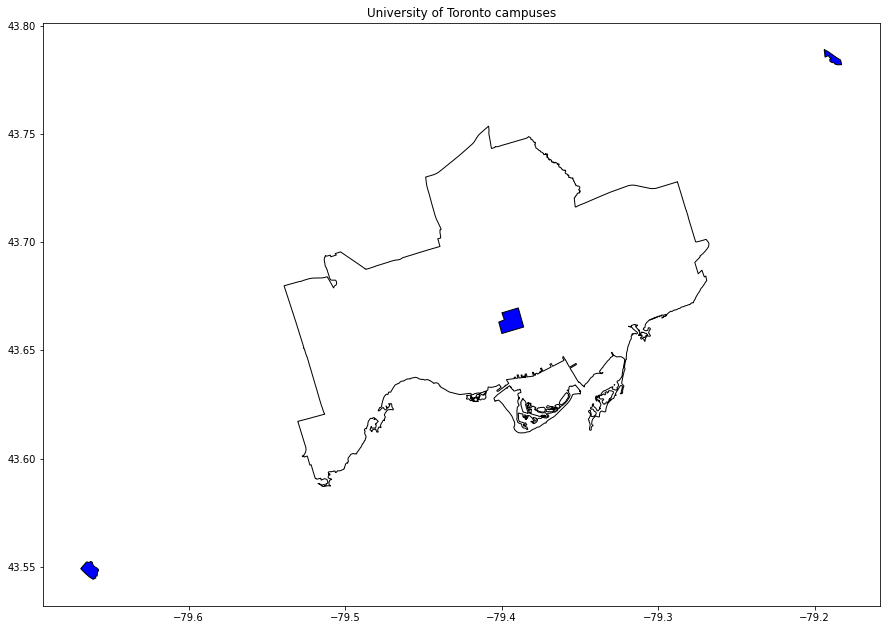

In [8]:
import matplotlib.pyplot as plt

# This file was created using the QGIS Editor
uoft = gpd.read_file(r"../../data/QGIS/UofT.shp")

fig, ax = plt.subplots(figsize=(15,15))

toronto = ontario[(ontario.REGION == "Toronto")]
t = toronto.plot(ax=ax, color='none',edgecolor='black')
t.set_title("University of Toronto campuses")
uoft.plot(ax=ax, color='blue', edgecolor='black')

This is nice, but we can see that two of the polygons (two campuses of the University of Toronto) are floating in the middle of nowhere. That's because our Ontario dataset only encompasses most of downtown Toronto, but ignores the other boroughs. Let's use a Toronto municipal map instead. In this example, we'll actually read the input as a `.geojson` file. It works the same way as `.shp` files. Let's use the Toronto municipalities as a base layer, and plot the University of Toronto campuses on top of it.

<AxesSubplot:title={'center':'University of Toronto campuses'}>

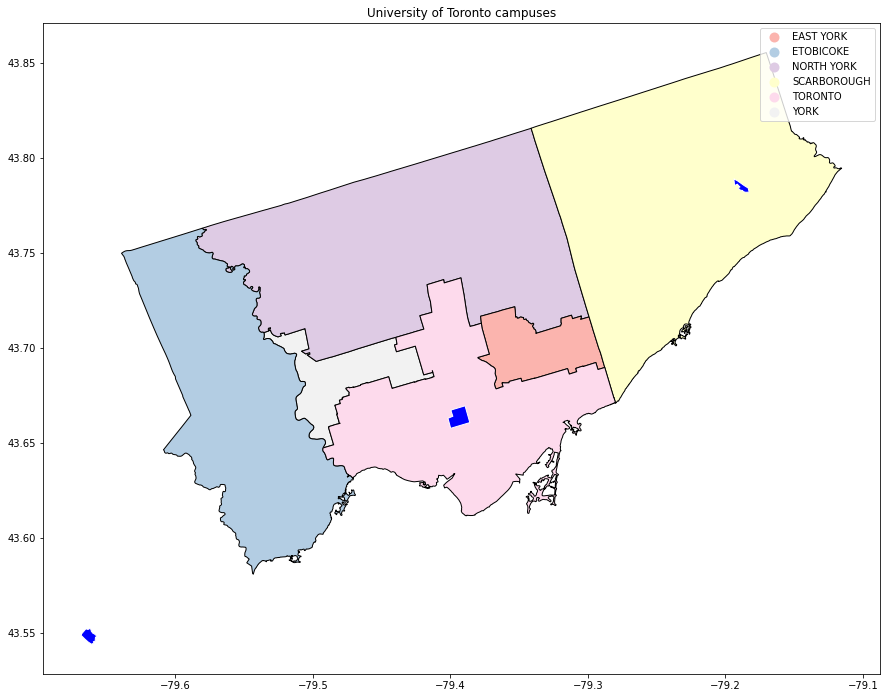

In [10]:
fig, ax = plt.subplots(figsize=(15,15))
toronto = gpd.read_file(r"../../data/ontario_health_regions/TorontoBoundary.geojson")
t = toronto.plot(ax=ax, cmap='Pastel1', edgecolor='black', column='AREA_NAME', figsize=(15,15), legend=True)
t.set_title("University of Toronto campuses")
uoft.plot(ax=ax, color='blue', edgecolor='white')

Almost there! The Mississauga campus (bottom left) is still in limbo. That's because Mississauga is part of Peel Region, which is outside of Toronto. Let's redo the map, including the Mississauga boundaries! This time, we'll use a `.kml` file for the input. KML files are not supported by default by `geopandas`, so we'll need to use a "driver" to read it. Fortunately, we can leverage `fiona`, a powerful python IO API, which is already built into `geopandas`.

In [11]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
missisauga = gpd.read_file(r"../../data/ontario_health_regions/MissBoundary.kml",driver='KML')
missisauga

,Name,Description,geometry
0,,,"MULTIPOLYGON (((-79.63657 43.73509, -79.63405 ..."


In [12]:
new_row = {
    'AREA_NAME' : 'MISSISSAUGA',
    'geometry': missisauga['geometry'][0]
}
gta = toronto.append(new_row, ignore_index=True)

Now let's try plotting the University of Toronto campuses again...

<AxesSubplot:title={'center':'University of Toronto campuses'}>

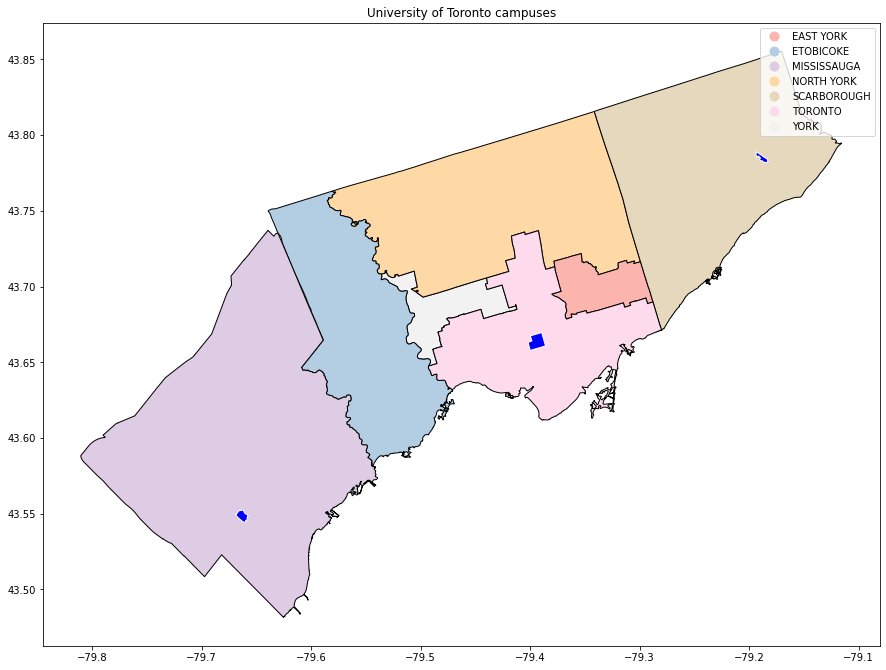

In [13]:
fig, ax = plt.subplots(figsize=(15,15))
g = gta.plot(ax=ax, cmap='Pastel1', edgecolor='black', column='AREA_NAME', figsize=(15,15), legend=True)
g.set_title("University of Toronto campuses")
uoft.plot(ax=ax, color='blue', edgecolor='white')

:::{admonition} Going further
:class: tip
As an exercise, we could try adding Markers and/or Popups to the campuses, to show their names when clicked. Alternatively we could also change the basemap layer to a road network map (like OpenStreetMap), and plot the shortest distance (by road) between the campuses...
:::